**Data Pre-processing**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from tensorflow.keras.utils import to_categorical


df = pd.read_csv('weatherAUS.csv')
df = df.drop(columns=[
    'Date', 'Evaporation', 'Sunshine', 'Cloud9am', 'Cloud3pm', 'RISK_MM'
], errors='ignore')

df = df.dropna(subset=['RainTomorrow'])

#this is the 3-class clasisfication done!
def classify_rain(row):
    if row['RainTomorrow'] == 'No':
        return 0
    elif row['Rainfall'] < 5:
        return 1
    else:
        return 2

df['RainClass'] = df.apply(classify_rain, axis=1)
df = df.drop(columns=['RainTomorrow', 'Rainfall'])

cat_cols = df.select_dtypes(include='object').columns
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))


imputer = SimpleImputer(strategy='mean')
df[df.columns] = imputer.fit_transform(df)


X = df.drop(columns=['RainClass']).values
y = df['RainClass'].values


y_cat = to_categorical(y, num_classes=3)


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#normal splitting
X_train, X_test, y_train_cat, y_test_cat, y_train, y_test = train_test_split(
    X_scaled, y_cat, y, test_size=0.2, random_state=42
)


In [ ]:
#neural net
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train_cat,
    validation_split=0.2,
    epochs=50,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

test_loss, test_acc = model.evaluate(X_test, y_test_cat, verbose=0)
print(f"\n--- ANN with Dropout ---")
print(f"Test Accuracy: {test_acc:.4f}")


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1422/1422 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7699 - loss: 0.5725 - val_accuracy: 0.8191 - val_loss: 0.4350
Epoch 2/50
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8179 - loss: 0.4482 - val_accuracy: 0.8211 - val_loss: 0.4289
Epoch 3/50
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8156 - loss: 0.4473 - val_accuracy: 0.8210 - val_loss: 0.4264
Epoch 4/50
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8193 - loss: 0.4395 - val_accuracy: 0.8223 - val_loss: 0.4252
Epoch 5/50
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8199 - loss: 0.4384 - val_accuracy: 0.8216 - val_loss: 0.4213
Epoch 6/50
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8201 - loss: 0.4349 - val_accuracy: 0.8235 - val_loss: 0.4210
Epoch 7/50
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8193 - loss: 0.4344 - val_accuracy: 0.8230 - val_loss: 0.4192
Epoch 8/50
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8237 - loss: 0.4281 - val_accurac

In [ ]:
#lr
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)

y_pred_logreg = log_reg.predict(X_test)

logreg_acc = accuracy_score(y_test, y_pred_logreg)
print(f"\n--- Logistic Regression ---")
print(f"Test Accuracy: {logreg_acc:.4f}")



--- Logistic Regression ---
Test Accuracy: 0.8159


889/889 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  


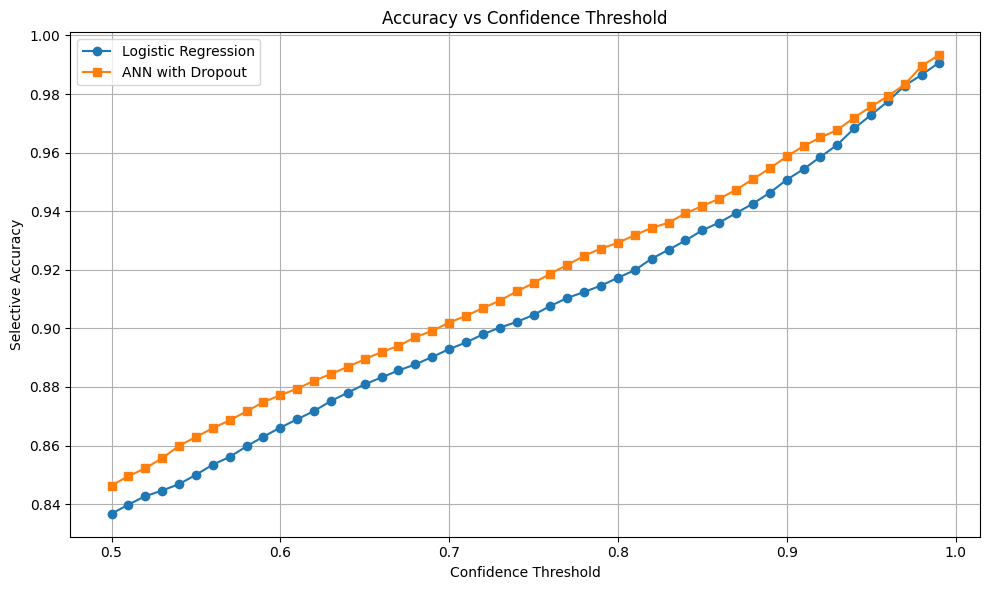

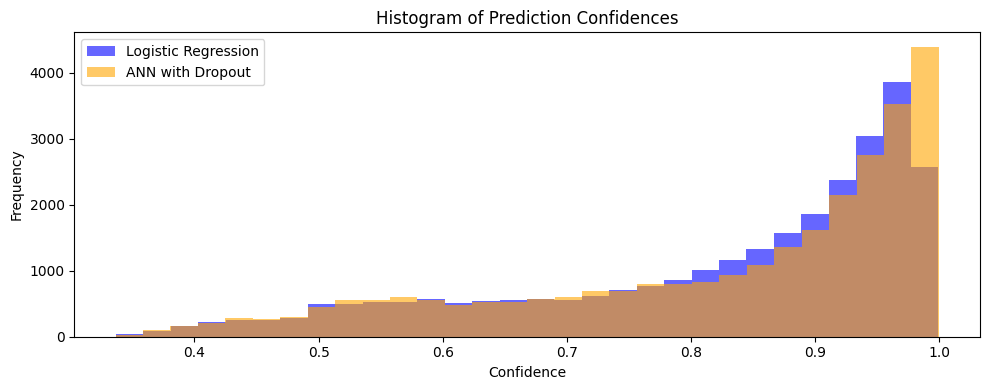

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score


y_proba_logreg = log_reg.predict_proba(X_test)
y_proba_ann = model.predict(X_test)


conf_logreg = np.max(y_proba_logreg, axis=1)
pred_logreg = np.argmax(y_proba_logreg, axis=1)

conf_ann = np.max(y_proba_ann, axis=1)
pred_ann = np.argmax(y_proba_ann, axis=1)


thresholds = np.linspace(0.5, 0.99, 50)
logreg_accs, ann_accs, coverages = [], [], []

for t in thresholds:
    idx_logreg = conf_logreg >= t
    idx_ann = conf_ann >= t

    if np.sum(idx_logreg) > 0 and np.sum(idx_ann) > 0:
        acc_logreg = accuracy_score(y_test[idx_logreg], pred_logreg[idx_logreg])
        acc_ann = accuracy_score(y_test[idx_ann], pred_ann[idx_ann])
        coverage = np.mean(idx_ann)

        logreg_accs.append(acc_logreg)
        ann_accs.append(acc_ann)
        coverages.append(coverage)
    else:
        logreg_accs.append(np.nan)
        ann_accs.append(np.nan)
        coverages.append(np.nan)

#plot1
plt.figure(figsize=(10, 6))
plt.plot(thresholds, logreg_accs, label='Logistic Regression', marker='o')
plt.plot(thresholds, ann_accs, label='ANN with Dropout', marker='s')
plt.xlabel('Confidence Threshold')
plt.ylabel('Selective Accuracy')
plt.title('Accuracy vs Confidence Threshold')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#p2
plt.figure(figsize=(10, 4))
plt.hist(conf_logreg, bins=30, alpha=0.6, label='Logistic Regression', color='blue')
plt.hist(conf_ann, bins=30, alpha=0.6, label='ANN with Dropout', color='orange')
plt.xlabel('Confidence')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Confidences')
plt.legend()
plt.tight_layout()
plt.show()


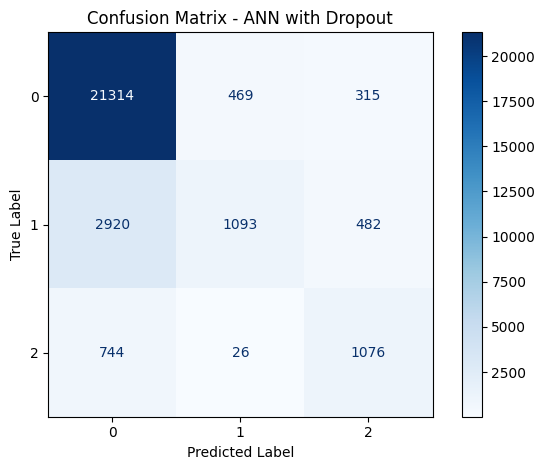

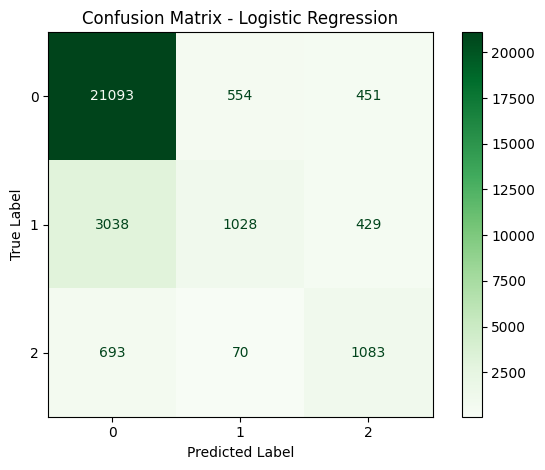

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#annex work and plots
cm_ann = confusion_matrix(y_test, pred_ann)
disp_ann = ConfusionMatrixDisplay(confusion_matrix=cm_ann)
disp_ann.plot(cmap='Blues')
plt.title("Confusion Matrix - ANN with Dropout")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.grid(False)
plt.tight_layout()
plt.show()


cm_log = confusion_matrix(y_test, pred_logreg)
disp_log = ConfusionMatrixDisplay(confusion_matrix=cm_log)
disp_log.plot(cmap='Greens')
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.grid(False)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np

def compute_ece(confidences, predictions, true_labels, n_bins=10):
    """
    Compute Expected Calibration Error (ECE)

    Parameters:
        confidences (np.array): Predicted confidence scores (max softmax probability)
        predictions (np.array): Predicted class indices
        true_labels (np.array): Ground truth labels
        n_bins (int): Number of bins to divide confidence interval [0,1]

    Returns:
        float: ECE score
    """
    bin_bounds = np.linspace(0.0, 1.0, n_bins + 1)
    ece = 0.0

    for i in range(n_bins):
        bin_lower = bin_bounds[i]
        bin_upper = bin_bounds[i + 1]

        in_bin = (confidences > bin_lower) & (confidences <= bin_upper)
        prop_in_bin = np.mean(in_bin)

        if prop_in_bin > 0:
            acc_in_bin = np.mean(predictions[in_bin] == true_labels[in_bin])
            avg_conf_in_bin = np.mean(confidences[in_bin])
            ece += prop_in_bin * abs(acc_in_bin - avg_conf_in_bin)

    return ece

ece_log = compute_ece(conf_logreg, pred_logreg, y_test)
ece_ann = compute_ece(conf_ann, pred_ann, y_test)

print("\n--- Calibration Error (ECE) ---")
print(f"ECE - Logistic Regression: {ece_log:.4f}")
print(f"ECE - ANN with Dropout:   {ece_ann:.4f}")



--- Calibration Error (ECE) ---
ECE - Logistic Regression: 0.0071
ECE - ANN with Dropout:   0.0030


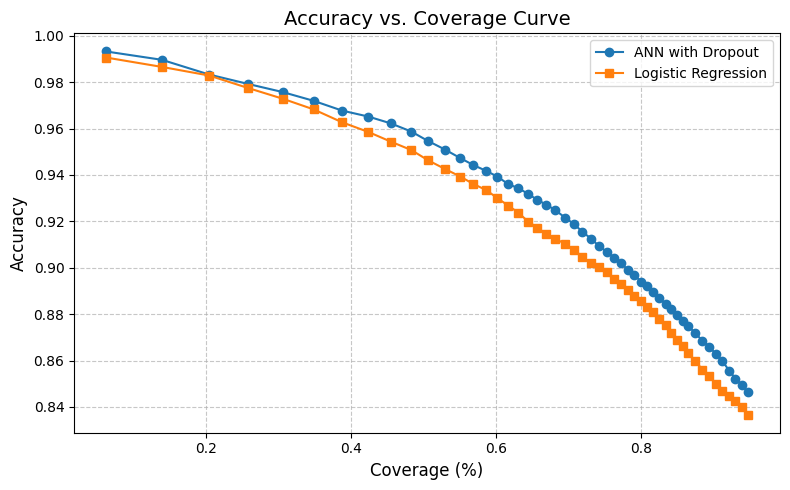

In [ ]:
import matplotlib.pyplot as plt
#information
#coverage: percentage of predictions retained after confidence thresholding
#ann_accs: accuracy of ANN at each coverage level
#logreg_accs: accuracy of logistic regression at each coverage level

plt.figure(figsize=(8, 5))
plt.plot(coverages, ann_accs, marker='o', label='ANN with Dropout')
plt.plot(coverages, logreg_accs, marker='s', label='Logistic Regression')

plt.xlabel("Coverage (%)", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.title("Accuracy vs. Coverage Curve", fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import classification_report

print("\n--- Classification Report: Logistic Regression ---")
print(classification_report(y_test, pred_logreg, digits=4))

print("\n--- Classification Report: ANN with Dropout ---")
print(classification_report(y_test, pred_ann, digits=4))



--- Classification Report: Logistic Regression ---
              precision    recall  f1-score   support

         0.0     0.8497    0.9545    0.8991     22098
         1.0     0.6223    0.2287    0.3345      4495
         2.0     0.5517    0.5867    0.5687      1846

    accuracy                         0.8159     28439
   macro avg     0.6746    0.5900    0.6007     28439
weighted avg     0.7944    0.8159    0.7884     28439


--- Classification Report: ANN with Dropout ---
              precision    recall  f1-score   support

         0.0     0.8533    0.9645    0.9055     22098
         1.0     0.6883    0.2432    0.3594      4495
         2.0     0.5745    0.5829    0.5787      1846

    accuracy                         0.8257     28439
   macro avg     0.7054    0.5969    0.6145     28439
weighted avg     0.8091    0.8257    0.7980     28439



**Now Testing With LDA ( reduced to 2 Features only (2D) )**

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

#reduce feature dimensions from 16 to 2
lda = LinearDiscriminantAnalysis(n_components=2)
X_train_lda = lda.fit_transform(X_train, y_train)
X_test_lda = lda.transform(X_test)

print(f"Original feature shape: {X_train.shape[1]}")
print(f"After LDA feature shape: {X_train_lda.shape[1]}")


log_reg_lda = LogisticRegression(max_iter=1000, random_state=42)
log_reg_lda.fit(X_train_lda, y_train)


y_pred_log_lda = log_reg_lda.predict(X_test_lda)
acc_log_lda = accuracy_score(y_test, y_pred_log_lda)

print(f"\n--- Logistic Regression (LDA Features) ---")
print(f"Test Accuracy: {acc_log_lda:.4f}")


Original feature shape: 16
After LDA feature shape: 2

--- Logistic Regression (LDA Features) ---
Test Accuracy: 0.8148


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


model_lda = Sequential([
    Dense(32, activation='relu', input_shape=(X_train_lda.shape[1],)),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])


model_lda.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


early_stop = EarlyStopping(patience=5, restore_best_weights=True)


history_lda = model_lda.fit(
    X_train_lda, y_train_cat,
    validation_split=0.2,
    epochs=30,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

loss_lda, acc_lda = model_lda.evaluate(X_test_lda, y_test_cat, verbose=0)
print(f"\n--- ANN With Dropout (LDA Features) ---")
print(f"Test Accuracy: {acc_lda:.4f}")


Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1422/1422 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.7565 - loss: 0.6079 - val_accuracy: 0.8161 - val_loss: 0.4408
Epoch 2/30
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8080 - loss: 0.4657 - val_accuracy: 0.8153 - val_loss: 0.4403
Epoch 3/30
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8094 - loss: 0.4609 - val_accuracy: 0.8159 - val_loss: 0.4387
Epoch 4/30
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8103 - loss: 0.4554 - val_accuracy: 0.8159 - val_loss: 0.4405
Epoch 5/30
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8107 - loss: 0.4576 - val_accuracy: 0.8164 - val_loss: 0.4384
Epoch 6/30
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8108 - loss: 0.4547 - val_accuracy: 0.8166 - val_loss: 0.4384
Epoch 7/30
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8111 - loss: 0.4556 - val_accuracy: 0.8163 - val_loss: 0.4388
Epoch 8/30
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8115 - loss: 0.4542 - val_accurac

In [ ]:
print("\n--- Feature Dimensionality Reduction ---")
print(f"Original Feature Shape: {X_train.shape[1]} features")
print(f"After LDA Reduction:     {X_train_lda.shape[1]} features")



--- Feature Dimensionality Reduction ---
Original Feature Shape: 16 features
After LDA Reduction:     2 features


In [ ]:
import numpy as np


y_proba_log_lda = log_reg_lda.predict_proba(X_test_lda)
conf_log_lda = np.max(y_proba_log_lda, axis=1)
pred_log_lda = np.argmax(y_proba_log_lda, axis=1)

y_proba_ann_lda = model_lda.predict(X_test_lda, verbose=0)
conf_ann_lda = np.max(y_proba_ann_lda, axis=1)
pred_ann_lda = np.argmax(y_proba_ann_lda, axis=1)


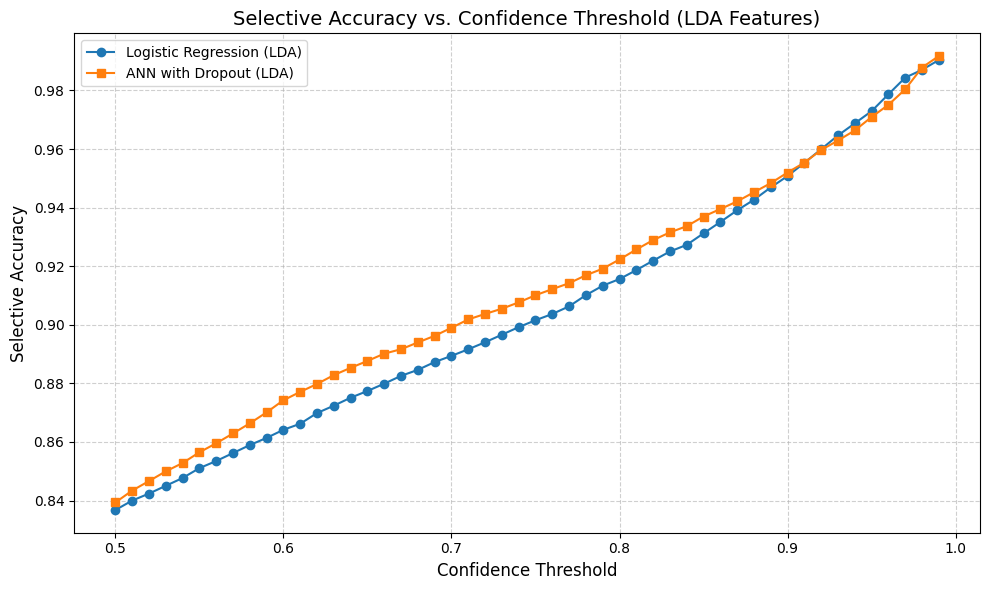

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

thresholds = np.linspace(0.5, 0.99, 50)
logreg_accs_lda, ann_accs_lda, coverages_lda = [], [], []

for t in thresholds:
    idx_log = conf_log_lda >= t
    idx_ann = conf_ann_lda >= t

    if np.sum(idx_log) > 0 and np.sum(idx_ann) > 0:
        acc_log = accuracy_score(y_test[idx_log], pred_log_lda[idx_log])
        acc_ann = accuracy_score(y_test[idx_ann], pred_ann_lda[idx_ann])
        coverage = np.mean(idx_ann)

        logreg_accs_lda.append(acc_log)
        ann_accs_lda.append(acc_ann)
        coverages_lda.append(coverage)
    else:
        logreg_accs_lda.append(np.nan)
        ann_accs_lda.append(np.nan)
        coverages_lda.append(np.nan)

plt.figure(figsize=(10, 6))
plt.plot(thresholds, logreg_accs_lda, label='Logistic Regression (LDA)', marker='o')
plt.plot(thresholds, ann_accs_lda, label='ANN with Dropout (LDA)', marker='s')

plt.xlabel('Confidence Threshold', fontsize=12)
plt.ylabel('Selective Accuracy', fontsize=12)
plt.title('Selective Accuracy vs. Confidence Threshold (LDA Features)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


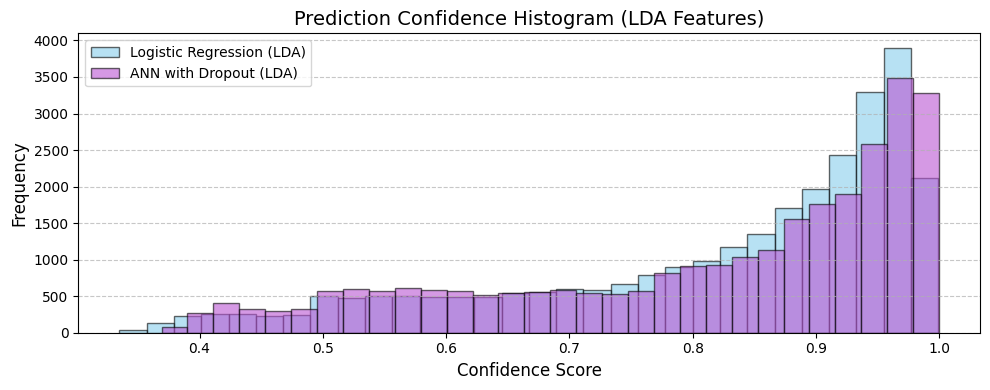

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))

plt.hist(conf_log_lda, bins=30, alpha=0.6, label='Logistic Regression (LDA)', color='skyblue', edgecolor='black')
plt.hist(conf_ann_lda, bins=30, alpha=0.6, label='ANN with Dropout (LDA)', color='mediumorchid', edgecolor='black')

plt.xlabel('Confidence Score', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Prediction Confidence Histogram (LDA Features)', fontsize=14)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


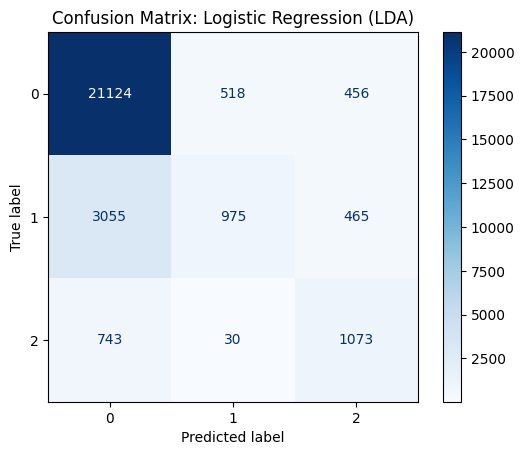

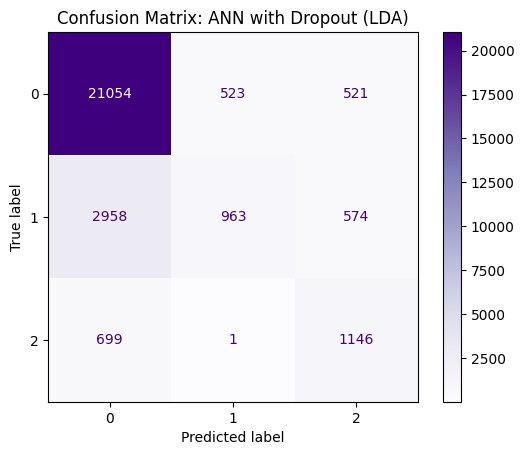

In [ ]:
#with lda, annex, confusin matrix and plots
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm_log_lda = confusion_matrix(y_test, pred_log_lda)
disp_log_lda = ConfusionMatrixDisplay(confusion_matrix=cm_log_lda)
disp_log_lda.plot(cmap='Blues')
plt.title("Confusion Matrix: Logistic Regression (LDA)")
plt.grid(False)
plt.show()

cm_ann_lda = confusion_matrix(y_test, pred_ann_lda)
disp_ann_lda = ConfusionMatrixDisplay(confusion_matrix=cm_ann_lda)
disp_ann_lda.plot(cmap='Purples')
plt.title("Confusion Matrix: ANN with Dropout (LDA)")
plt.grid(False)
plt.show()


In [ ]:

import numpy as np

def compute_ece(confidences, predictions, true_labels, n_bins=10):
    """
    Computes Expected Calibration Error (ECE).
    Splits the confidence range [0,1] into bins and measures
    the difference between confidence and accuracy per bin.
    """
    bin_bounds = np.linspace(0.0, 1.0, n_bins + 1)
    ece = 0.0

    for i in range(n_bins):
        bin_lower, bin_upper = bin_bounds[i], bin_bounds[i + 1]
        in_bin = (confidences > bin_lower) & (confidences <= bin_upper)
        prop_in_bin = np.mean(in_bin)

        if prop_in_bin > 0:
            acc_in_bin = np.mean(predictions[in_bin] == true_labels[in_bin])
            avg_conf = np.mean(confidences[in_bin])
            ece += prop_in_bin * abs(acc_in_bin - avg_conf)

    return ece

ece_log_lda = compute_ece(conf_log_lda, pred_log_lda, y_test)
ece_ann_lda = compute_ece(conf_ann_lda, pred_ann_lda, y_test)

print("\n--- Expected Calibration Error (ECE) - LDA ---")
print(f"Logistic Regression (LDA): {ece_log_lda:.4f}")
print(f"ANN with Dropout (LDA):   {ece_ann_lda:.4f}")



--- Expected Calibration Error (ECE) - LDA ---
Logistic Regression (LDA): 0.0090
ANN with Dropout (LDA):   0.0059


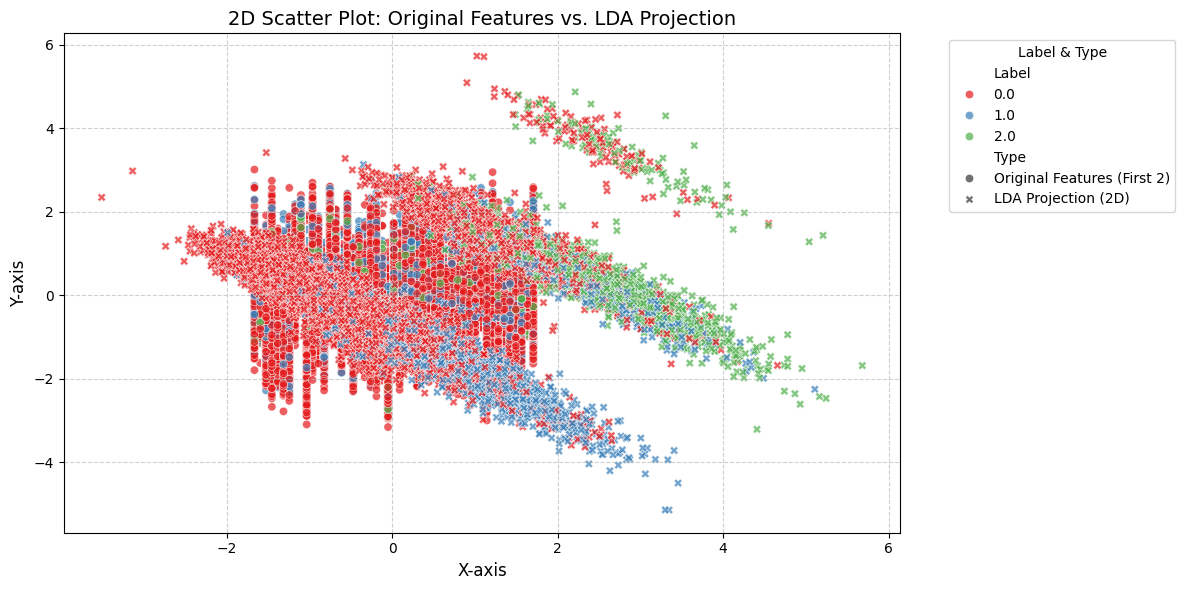

In [ ]:
#scatter plots
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

#original
X_vis = X_test[:, :2]
df_orig = pd.DataFrame(X_vis, columns=['X', 'Y'])
df_orig['Label'] = y_test
df_orig['Type'] = 'Original Features (First 2)'

#LDA-transformed features (2D)
df_lda = pd.DataFrame(X_test_lda, columns=['X', 'Y'])
df_lda['Label'] = y_test
df_lda['Type'] = 'LDA Projection (2D)'

#combine
df_all = pd.concat([df_orig, df_lda])

plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=df_all, x='X', y='Y', hue='Label', style='Type', alpha=0.7, palette='Set1'
)
plt.title('2D Scatter Plot: Original Features vs. LDA Projection', fontsize=14)
plt.xlabel("X-axis", fontsize=12)
plt.ylabel("Y-axis", fontsize=12)
plt.legend(title='Label & Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


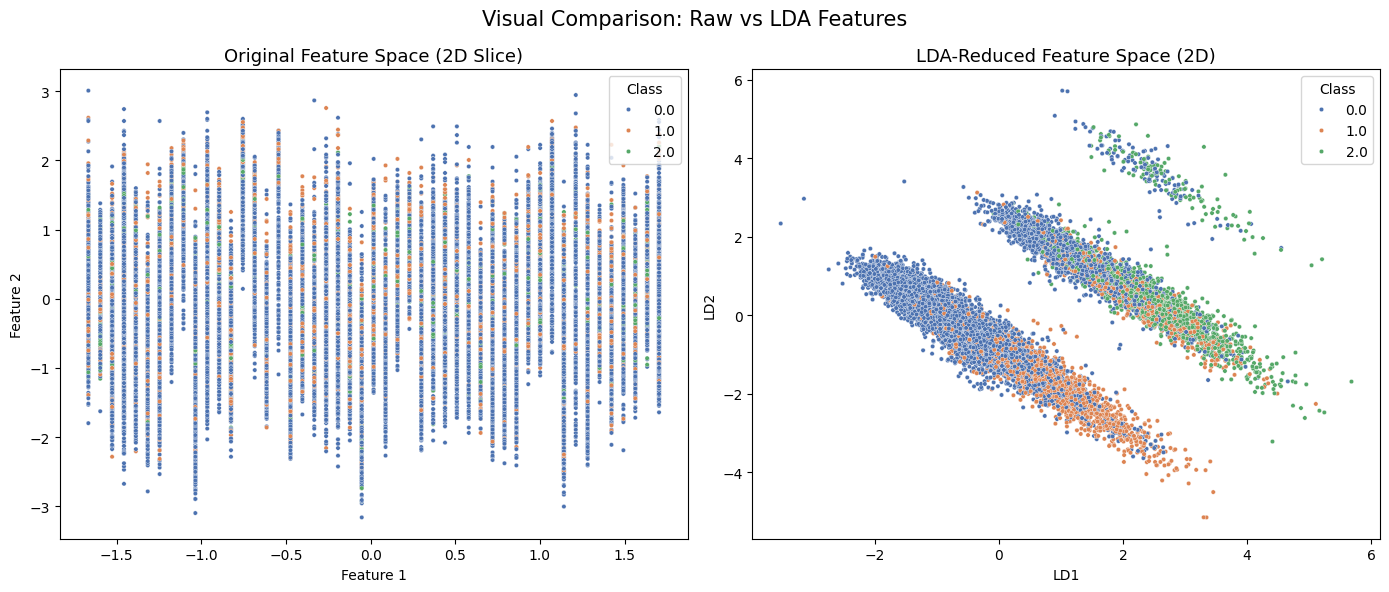

In [ ]:
#side by side

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

df_orig = pd.DataFrame(X_test[:, :2], columns=['Feature 1', 'Feature 2'])
df_orig['Label'] = y_test

df_lda = pd.DataFrame(X_test_lda, columns=['LD1', 'LD2'])
df_lda['Label'] = y_test

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

#original
sns.scatterplot(
    data=df_orig,
    x='Feature 1', y='Feature 2',
    hue='Label',
    palette='deep',
    s=10,
    ax=axes[0]
)
axes[0].set_title('Original Feature Space (2D Slice)', fontsize=13)
axes[0].legend(title='Class', loc='upper right')

#lda
sns.scatterplot(
    data=df_lda,
    x='LD1', y='LD2',
    hue='Label',
    palette='deep',
    s=10,
    ax=axes[1]
)
axes[1].set_title('LDA-Reduced Feature Space (2D)', fontsize=13)
axes[1].legend(title='Class', loc='upper right')

plt.suptitle("Visual Comparison: Raw vs LDA Features", fontsize=15)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import classification_report
import numpy as np

print("\n--- Classification Report: Logistic Regression (Full) ---")
y_pred_log = log_reg.predict(X_test)
print(classification_report(y_test, y_pred_log, digits=4))

print("\n--- Classification Report: ANN with Dropout (Full) ---")
y_pred_ann = np.argmax(model.predict(X_test), axis=1)
print(classification_report(y_test, y_pred_ann, digits=4))



--- Classification Report: Logistic Regression (Full) ---
              precision    recall  f1-score   support

         0.0     0.8497    0.9545    0.8991     22098
         1.0     0.6223    0.2287    0.3345      4495
         2.0     0.5517    0.5867    0.5687      1846

    accuracy                         0.8159     28439
   macro avg     0.6746    0.5900    0.6007     28439
weighted avg     0.7944    0.8159    0.7884     28439


--- Classification Report: ANN with Dropout (Full) ---
889/889 ━━━━━━━━━━━━━━━━━━━━ 1s 973us/step
              precision    recall  f1-score   support

         0.0     0.8533    0.9645    0.9055     22098
         1.0     0.6883    0.2432    0.3594      4495
         2.0     0.5745    0.5829    0.5787      1846

    accuracy                         0.8257     28439
   macro avg     0.7054    0.5969    0.6145     28439
weighted avg     0.8091    0.8257    0.7980     28439



In [ ]:
model.count_params()


3267

In [ ]:
import time

start = time.time()
log_reg.fit(X_train, y_train)
end = time.time()
print(f"Training Time - Logistic Regression: {end - start:.2f} seconds")


Training Time - Logistic Regression: 4.26 seconds


In [ ]:
start = time.time()
model.fit(X_train, y_train_cat, epochs=30, batch_size=64, verbose=0)
end = time.time()
print(f"Training Time - ANN with Dropout: {end - start:.2f} seconds")


Training Time - ANN with Dropout: 133.99 seconds


In [ ]:
from scipy.stats import ttest_rel

correct_lda = (pred_log_lda == y_test).astype(int)
correct_orig = (pred_logreg == y_test).astype(int)

t_stat, p_val = ttest_rel(correct_lda, correct_orig)
print(f"T-stat: {t_stat:.4f}, P-value: {p_val:.4f}")


T-stat: -1.2571, P-value: 0.2087


In [ ]:
print("Original shape:", X_train.shape)
print("After LDA:", X_train_lda.shape)


Original shape: (113754, 16)
After LDA: (113754, 2)


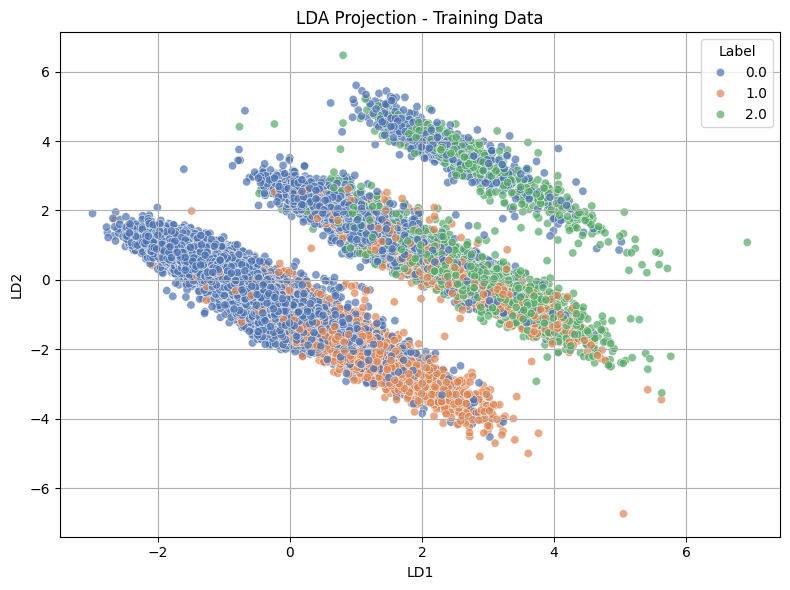

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

df_lda_plot = pd.DataFrame(X_train_lda, columns=["LD1", "LD2"])
df_lda_plot["Label"] = y_train

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_lda_plot, x="LD1", y="LD2", hue="Label", palette="deep", alpha=0.7)
plt.title("LDA Projection - Training Data")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
print("Logistic Accuracy (Full):", accuracy_score(y_test, pred_logreg))
print("Logistic Accuracy (LDA):", accuracy_score(y_test, pred_log_lda))


Logistic Accuracy (Full): 0.8159217975315588
Logistic Accuracy (LDA): 0.8147965821583038


In [ ]:
print("Explained by LDA components:", lda.explained_variance_ratio_)


Explained by LDA components: [0.82195902 0.17804098]


In [ ]:
print(lda.explained_variance_ratio_)
print("Total retained:", sum(lda.explained_variance_ratio_))


[0.82195902 0.17804098]
Total retained: 1.0


In [ ]:
# Print model summary (includes total parameters)
model.summary()

# Or just get the number of trainable parameters
total_params = model.count_params()
print(f"Trainable Parameters: {total_params}")


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 64)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,803 (38.30 KB)

 Trainable params: 3,267 (12.76 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,536 (25.54 KB)

Trainable Parameters: 3267


In [ ]:
params = log_reg.coef_.size + log_reg.intercept_.size
print(f"Logistic Regression Parameters: {params}")


Logistic Regression Parameters: 51


In [ ]:
import time

start_time = time.time()
log_reg_lda = LogisticRegression(max_iter=1000)
log_reg_lda.fit(X_train_lda, y_train)
log_train_time = time.time() - start_time
print(f"Training Time - Logistic Regression (LDA): {log_train_time:.2f} seconds")

log_params_lda = log_reg_lda.coef_.size + log_reg_lda.intercept_.size
print(f"Logistic Regression (LDA) Parameters: {log_params_lda}")


Training Time - Logistic Regression (LDA): 0.37 seconds
Logistic Regression (LDA) Parameters: 9


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import time

model_lda = Sequential()
model_lda.add(Dense(32, activation='relu', input_shape=(X_train_lda.shape[1],)))
model_lda.add(Dropout(0.3))
model_lda.add(Dense(16, activation='relu'))
model_lda.add(Dropout(0.3))
model_lda.add(Dense(3, activation='softmax'))

model_lda.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

early_stop = EarlyStopping(patience=5, restore_best_weights=True)
start_time = time.time()
model_lda.fit(X_train_lda, y_train_cat, validation_split=0.2, epochs=50, batch_size=64, callbacks=[early_stop], verbose=1)
ann_lda_time = time.time() - start_time
print(f"Training Time - ANN with Dropout (LDA): {ann_lda_time:.2f} seconds")

ann_lda_params = model_lda.count_params()
print(f"ANN with Dropout (LDA) Parameters: {ann_lda_params}")


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1422/1422 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6986 - loss: 0.6716 - val_accuracy: 0.8159 - val_loss: 0.4406
Epoch 2/50
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8084 - loss: 0.4640 - val_accuracy: 0.8163 - val_loss: 0.4388
Epoch 3/50
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8096 - loss: 0.4622 - val_accuracy: 0.8165 - val_loss: 0.4398
Epoch 4/50
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8110 - loss: 0.4534 - val_accuracy: 0.8174 - val_loss: 0.4376
Epoch 5/50
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8141 - loss: 0.4509 - val_accuracy: 0.8156 - val_loss: 0.4382
Epoch 6/50
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8119 - loss: 0.4538 - val_accuracy: 0.8157 - val_loss: 0.4381
Epoch 7/50
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8124 - loss: 0.4517 - val_accuracy: 0.8171 - val_loss: 0.4378
Epoch 8/50
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8110 - loss: 0.4544 - val_accurac